In [1]:
# https://www.kaggle.com/datasets/shubhammore12/nyc-311-customer-service-requests-analysis?datasetId=1481216
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
%matplotlib inline

In [2]:
df = pd.read_csv('NYC311data.csv')
df.info()

C:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300698 entries, 0 to 300697
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unique Key                      300698 non-null  int64  
 1   Created Date                    300698 non-null  object 
 2   Closed Date                     298534 non-null  object 
 3   Agency                          300698 non-null  object 
 4   Agency Name                     300698 non-null  object 
 5   Complaint Type                  300698 non-null  object 
 6   Descriptor                      294784 non-null  object 
 7   Location Type                   300567 non-null  object 
 8   Incident Zip                    298083 non-null  float64
 9   Incident Address                256288 non-null  object 
 10  Street Name                     256288 non-null  object 
 11  Cross Street 1                  251419 non-null  object 
 12  Cross Street 2  

# Cleaning Data

In [3]:
def convert_to_lower(df):
    #convert string columns into lowercase to elimintae duplication
    df = df.applymap(lambda s:s.lower() if type(s)==str else s)
    return df

def drop_empty_cols(df):
    #drop columns which are empty/almost empty
    na_col_count = df.isna().sum().where(lambda x:x>0).dropna()
    columns_to_drop = []
    for column in na_col_count.iteritems():
        if(column[1]/8275 >= 0.85):
            columns_to_drop.append(column[0])
    df.drop(columns_to_drop, axis=1, inplace=True)
    return df

def drop_unused_cols(df):
    #drop columns that will be unused
    cols = ['Descriptor','Location','Address Type','Facility Type','Agency','Agency Name','Community Board','Borough','Park Facility Name','Park Borough','School Region','School Code', 'School Name','School Number','School Phone Number','School Address','School City','School State','School Not Found','School Zip','X Coordinate (State Plane)','Y Coordinate (State Plane)']
    df.drop(cols,axis=1,inplace=True)
    return df

df = drop_unused_cols(df)
df = drop_empty_cols(df)
df = convert_to_lower(df)
df.info()

# identifying and counting missing values in columns
df.isna().sum().where(lambda x:x>0).dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300698 entries, 0 to 300697
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unique Key                      300698 non-null  int64  
 1   Created Date                    300698 non-null  object 
 2   Closed Date                     298534 non-null  object 
 3   Complaint Type                  300698 non-null  object 
 4   Location Type                   300567 non-null  object 
 5   Incident Zip                    298083 non-null  float64
 6   City                            298084 non-null  object 
 7   Status                          300698 non-null  object 
 8   Due Date                        300695 non-null  object 
 9   Resolution Description          300698 non-null  object 
 10  Resolution Action Updated Date  298511 non-null  object 
 11  Latitude                        297158 non-null  float64
 12  Longitude       

Closed Date                       2164.0
Location Type                      131.0
Incident Zip                      2615.0
City                              2614.0
Due Date                             3.0
Resolution Action Updated Date    2187.0
Latitude                          3540.0
Longitude                         3540.0
dtype: float64

# Request Closing Time

In [4]:
# dropping rows where closed & resolution date are empty - get rid of non-resolved cases
df = df[~(df['Closed Date'].isna() & df['Resolution Action Updated Date'].isna())]

# ensuring that closed date, resolution date and due date are all filled
df.loc[df['Resolution Action Updated Date'].isna(),'Resolution Action Updated Date'] = df[df['Resolution Action Updated Date'].isna()]['Closed Date']
df.loc[df['Closed Date'].isna(),'Closed Date'] = df[df['Closed Date'].isna()]['Resolution Action Updated Date']
df.loc[df['Due Date'].isna(),'Due Date'] = df[df['Due Date'].isna()]['Closed Date']

# closing all stauses since all rows are 'closed' and 'resolved'
df.loc[df.Status.isin(['open','assigned','draft']),'Status'] = 'closed'

In [5]:
#filling na values based on highest occuring value(mode)
#obtain mode
city = df.City.mode()[0]
zipcode = df.loc[df.City == city,'Incident Zip'].mode()[0]
latitude = df.loc[df['Incident Zip'] == zipcode,'Latitude'].mode()[0]
longitude = df.loc[df['Incident Zip'] == zipcode,'Longitude'].mode()[0]
#fill zipcode,latitude and longitude with modevalues where city is empty and then update city value to mode value
df.loc[df.City.isna(),'Incident Zip'] = zipcode
df.loc[df.City.isna(),'City'] = city
df.loc[(df.City == city) & (df.Latitude.isna()==True),'Latitude'] = latitude
df.loc[(df.City == city) & (df.Longitude.isna()==True),'Longitude'] = longitude

In [6]:
df.dropna(inplace=True)

In [7]:
df[['Created Date','Closed Date','Due Date','Resolution Action Updated Date']] = df[['Created Date','Closed Date','Due Date','Resolution Action Updated Date']].astype('datetime64[ns]')

In [8]:
# Find difference in beginning and closing times, convert time delta format to seconds
df.loc[:,'Request_Closing_Time'] = (df['Closed Date'] - df['Created Date']).dt.total_seconds()

# Complaints by Category

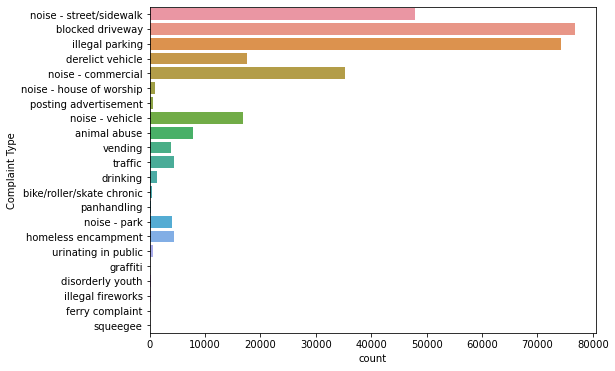

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, y='Complaint Type', ax = ax)
plt.show()

# Number of Complaints in each City

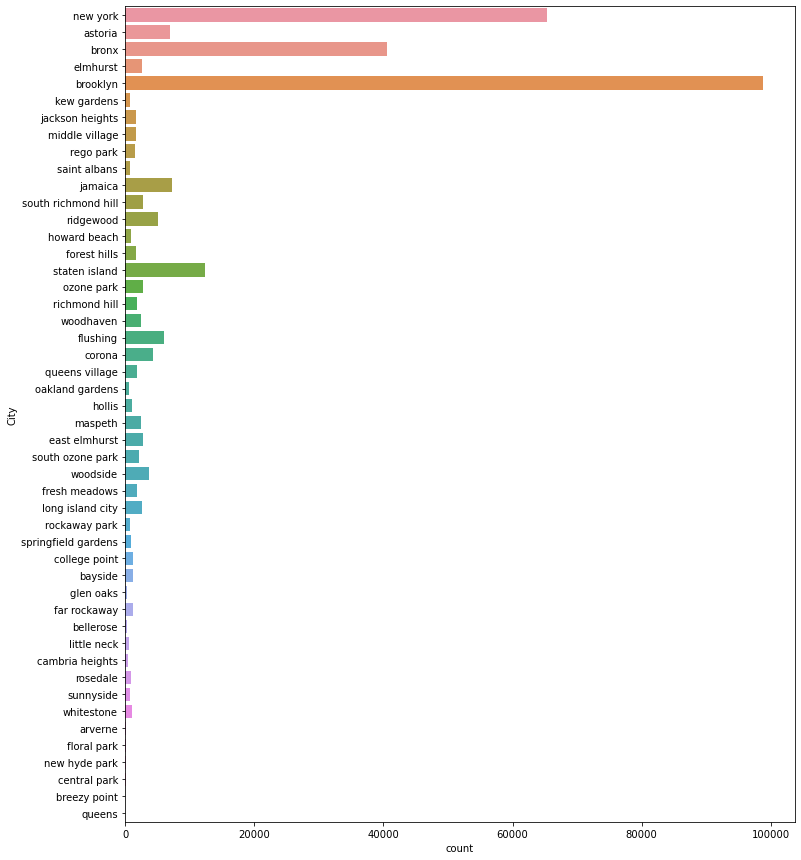

In [10]:
fig, ax = plt.subplots(figsize=(12, 15))
sns.countplot(data=df, y='City', ax = ax)
plt.show()

Cities like Brooklyn, New York and Bronx have the most complaints compared to other cities.

# Number of Incidents by Location Type

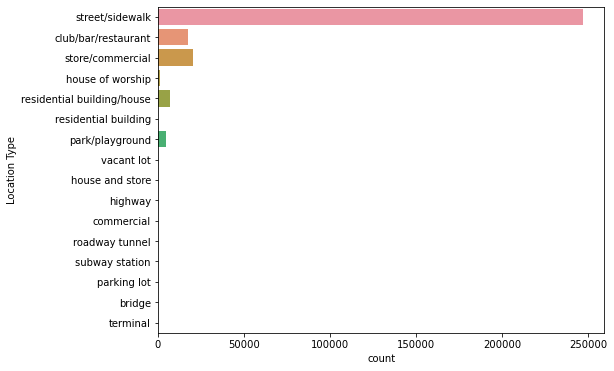

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, y='Location Type', ax = ax)
plt.show()

In [12]:
len(df[(df['Location Type']=='street/sidewalk')].value_counts())/len(df)

0.8293912903247482

Most complaints (82.9%) took place in the streets and sidewalks.

# Ordering the complaint types based on the average ‘Request_Closing_Time’, grouping them for different locations

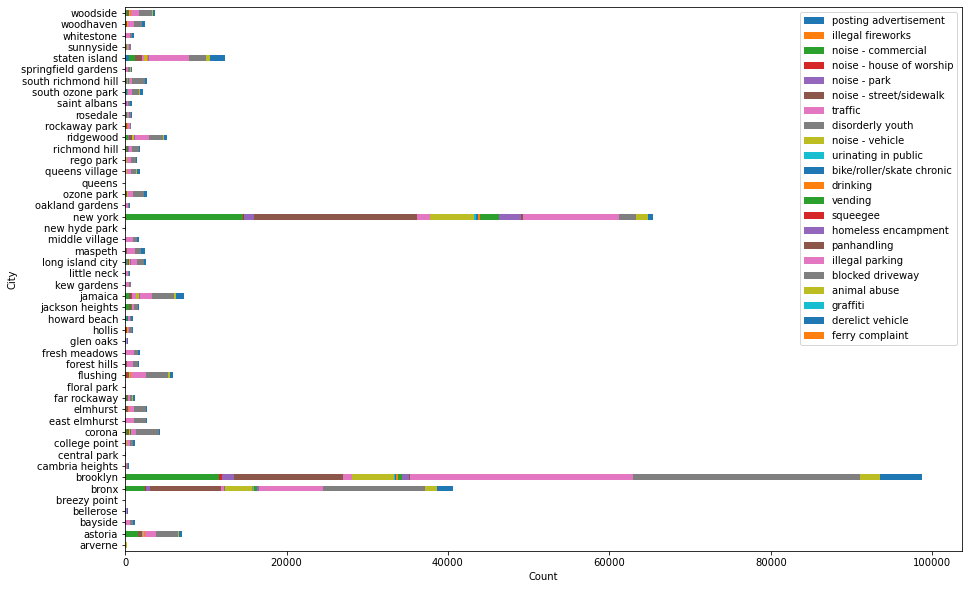

In [60]:
# Find order of average request closing times by complaint type, in ascending order and put it in a list
df2 = df.groupby(['Complaint Type'],as_index=False).mean().sort_values('Request_Closing_Time')
complaints_sorted_list = df2['Complaint Type'].values.tolist()

# Plot stacked bar chart, grouped by locations, ordering the complaint types based on average 'Request_Closing_Time'
# Source: https://stackoverflow.com/questions/58155668/plotting-a-stacked-bar-graph-after-grouping-data-on-multiple-columns
df_group_location_comp = df.groupby(['City','Complaint Type']).size().unstack()
df_group_location_comp['total']=df_group_location_comp.sum(axis=1)
fig, ax = plt.subplots(figsize=(15, 10))
df_group_location_comp[complaints_sorted_list].plot(kind='barh',stacked=True,ax=ax)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Count')
plt.show()

From this graph above, we can conclude that from the most of the complaints from brooklyn relate to illegal parking and blocked driveway incidents, while in new york, it relates to noise on the streets. The most common complaint among all cities is illegal parking.

# Statistical Test: Whether the average response time across complaint types is similar or not (overall)

The groups (of categorical data) can be compared with a simple chi-squared (or Fisher’s exact) test.

Use ANOVA to run a comparative analysis between 3 or more groups (or categories in this case). Use one-way ANOVA to compare one source of variability (Complaint type)

"In ANOVA, we consider two types of variances —
 1. Variance between the groups
 2. Variance within the groups"

Null Hypothesis: Sample groups’ means are equal. (i.e. the complaint type does not affect the response times)

Alternative Hypothesis: One or more groups’ means differ from the others. (i.e. the complaint type affects the response times)

In [58]:
grouper = df.groupby('Complaint Type')
df3 = pd.concat([pd.Series(v['Request_Closing_Time'].tolist(), name=k) for k, v in grouper], axis=1).dropna(axis=1, how='all')

df3.set_axis(['c{}'.format(i) for i in range(1,len(complaints_sorted_list)+1)], axis=1, inplace=True)
col_names = list(df3.columns.values)

for i in range(len(complaints_sorted_list)):
    exec("c{} = df3.loc[:,'c{}'].dropna()".format(i+1, i+1))

f_value, p_value = stats.f_oneway(c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22)
f_critical=stats.f.ppf(1-.05,dfn=21,dfd=297646)
print("f-value:",f_value)
print("Critical Value:",f_critical)

f-value: 3425.175861290569
Critical Value: 1.5557773144982863


Hence, the complaint type affects the average closing time of the requests as the F-value is greater than the Critical Value.

# Statistical Test: Are the type of complaint or service requested and location related?

In [64]:
crosstab_df = pd.crosstab(df['Complaint Type'],df['City'])
stat, p_val, deg_freedom, expect = chi2_contingency(crosstab_df)
print("Stat Value: ", stat)
print("p-value: ", p_val)
print("Degrees of freedom: ", deg_freedom)

Stat Value:  109359.08964937081
p-value:  0.0
Degrees of freedom:  987


Since value > p-value, we reject the null hypothesis. Complaint Service requested and Location are related.